In [1]:
import pandas as pd

ames_housing = pd.read_csv(
    "../datasets/ames_housing_no_missing.csv",
    na_filter=False,  # required for pandas>2.0
)
target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

In [2]:
ames_housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,250000


In [3]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ]
)

In [5]:
from sklearn.linear_model import LinearRegression

linear_model = make_pipeline(
    preprocessor,
    LinearRegression(),
)

In [6]:
cv_results = cross_validate(
    linear_model,
    data_numerical,
    target,
    cv=10,
    return_train_score=True,
    return_estimator=True,
)


In [7]:
test_score_lr = cv_results["test_score"]
test_score_lr

array([0.76129977, 0.80635105, 0.81358636, 0.66592199, 0.79964891,
       0.76868787, 0.75635094, 0.71822127, 0.31479306, 0.78635221])

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree = make_pipeline(
    preprocessor,
    DecisionTreeRegressor(random_state=0),
)

In [9]:
cv_results = cross_validate(
    tree,
    data_numerical,
    target,
    cv=10,
    return_train_score=True,
    return_estimator=True,
)

In [10]:
test_score_complex_lr = cv_results["test_score"]
test_score_complex_lr

array([0.61901627, 0.69388459, 0.70870548, 0.6002156 , 0.70972077,
       0.62009287, 0.51579096, 0.62799316, 0.42353424, 0.68396279])

A model using both all features is better than a model using only numerical features for 1 CV iterations out of 10.


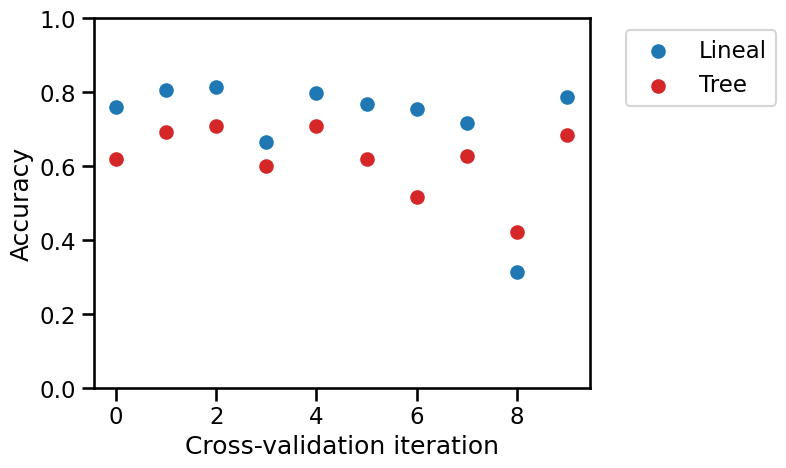

In [11]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.arange(len(test_score_lr))
plt.scatter(
    indices, test_score_lr, color="tab:blue", label="Lineal"
)
plt.scatter(
    indices,
    test_score_complex_lr,
    color="tab:red",
    label="Tree",
)
plt.ylim((0, 1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("Accuracy")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

print(
    "A model using both all features is better than a"
    " model using only numerical features for"
    f" {sum(test_score_complex_lr > test_score_lr)} CV iterations out of 10."
)

In [12]:
for parameter in tree.get_params():
    print(parameter)

memory
steps
verbose
columntransformer
decisiontreeregressor
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__verbose_feature_names_out
columntransformer__num
columntransformer__num__copy
columntransformer__num__with_mean
columntransformer__num__with_std
decisiontreeregressor__ccp_alpha
decisiontreeregressor__criterion
decisiontreeregressor__max_depth
decisiontreeregressor__max_features
decisiontreeregressor__max_leaf_nodes
decisiontreeregressor__min_impurity_decrease
decisiontreeregressor__min_samples_leaf
decisiontreeregressor__min_samples_split
decisiontreeregressor__min_weight_fraction_leaf
decisiontreeregressor__random_state
decisiontreeregressor__splitter


In [13]:
from sklearn.model_selection import GridSearchCV
import numpy as np


params = {"max_depth": np.arange(5, 9),
         "random_state": np.arange(0,2)}
search = GridSearchCV(DecisionTreeRegressor(random_state=0), params, cv=10)

In [14]:
cv_results_tree_optimal_depth = cross_validate(
    search, data_numerical, target, cv=10, return_estimator=True, n_jobs=2,
)

In [15]:
test_score_complex_lr_2 = cv_results_tree_optimal_depth["test_score"]
test_score_complex_lr_2

array([0.61254979, 0.75007937, 0.7092939 , 0.61593787, 0.7380518 ,
       0.72481088, 0.67908796, 0.76053576, 0.52936007, 0.72866512])

In [16]:
for search_cv in cv_results_tree_optimal_depth["estimator"]:
    print(search_cv.best_params_)

{'max_depth': 7, 'random_state': 1}
{'max_depth': 7, 'random_state': 0}
{'max_depth': 6, 'random_state': 0}
{'max_depth': 6, 'random_state': 0}
{'max_depth': 5, 'random_state': 1}
{'max_depth': 6, 'random_state': 0}
{'max_depth': 6, 'random_state': 1}
{'max_depth': 6, 'random_state': 1}
{'max_depth': 7, 'random_state': 1}
{'max_depth': 6, 'random_state': 0}


A model using both all features is better than a model using only numerical features for 2 CV iterations out of 10.


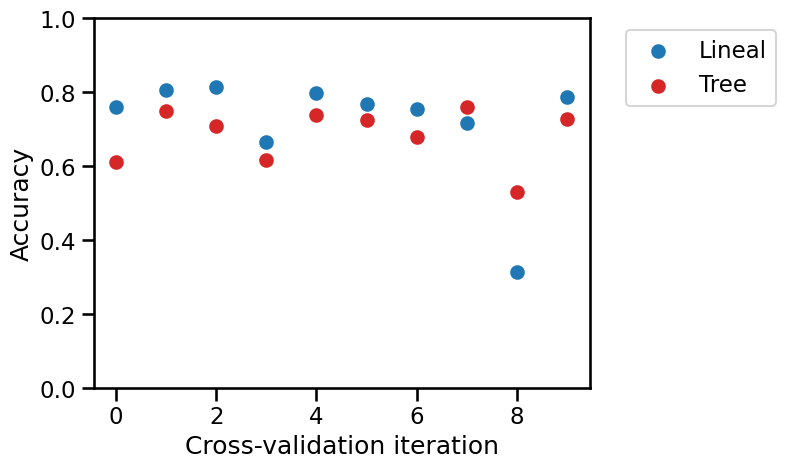

In [17]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.arange(len(test_score_lr))
plt.scatter(
    indices, test_score_lr, color="tab:blue", label="Lineal"
)
plt.scatter(
    indices,
    test_score_complex_lr_2,
    color="tab:red",
    label="Tree",
)
plt.ylim((0, 1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("Accuracy")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

print(
    "A model using both all features is better than a"
    " model using only numerical features for"
    f" {sum(test_score_complex_lr_2 > test_score_lr)} CV iterations out of 10."
)

In [18]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)

categorical_features = categorical_columns_selector(data)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('num', "passthrough", numerical_features)
    ]
)

In [20]:
from sklearn.model_selection import GridSearchCV
import numpy as np

tree_all = make_pipeline(
    preprocessor,
    DecisionTreeRegressor(max_depth=7),
)

In [21]:
params = {"decisiontreeregressor__random_state": np.arange(0,2)}
search = GridSearchCV(tree_all, param_grid=params, cv=10)

In [22]:
cv_results_tree_optimal_depth = cross_validate(
    search, data, target, cv=10, return_estimator=True, n_jobs=2,
)

In [23]:
all_features = cv_results_tree_optimal_depth["test_score"]
all_features

array([0.73912891, 0.7358024 , 0.78660116, 0.5016707 , 0.82038021,
       0.71412818, 0.78708023, 0.83192973, 0.66074552, 0.75851579])

A model using both all features is better than a model using only numerical features for 7 CV iterations out of 10.


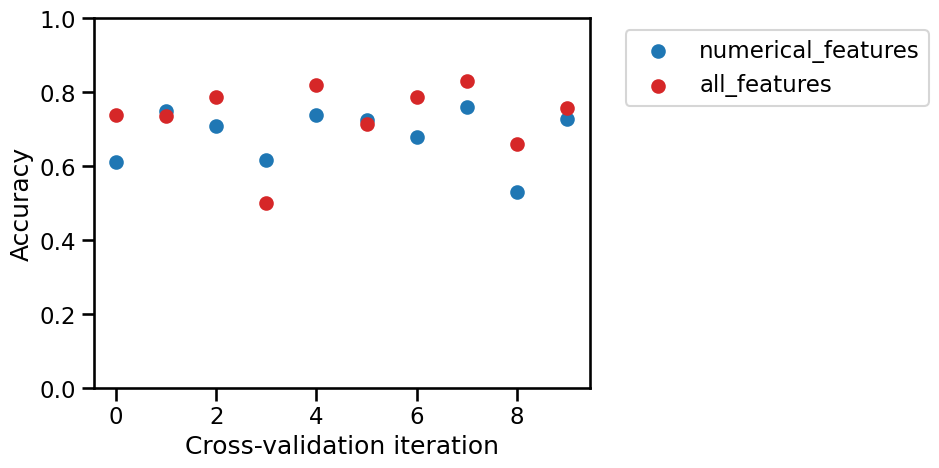

In [24]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.arange(len(test_score_complex_lr_2))
plt.scatter(
    indices, test_score_complex_lr_2, color="tab:blue", label="numerical_features"
)
plt.scatter(
    indices,
    all_features,
    color="tab:red",
    label="all_features",
)
plt.ylim((0, 1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("Accuracy")
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

print(
    "A model using both all features is better than a"
    " model using only numerical features for"
    f" {sum(all_features > test_score_complex_lr_2)} CV iterations out of 10."
)